In [3]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from mlxtend.plotting import plot_decision_regions
from PIL import Image

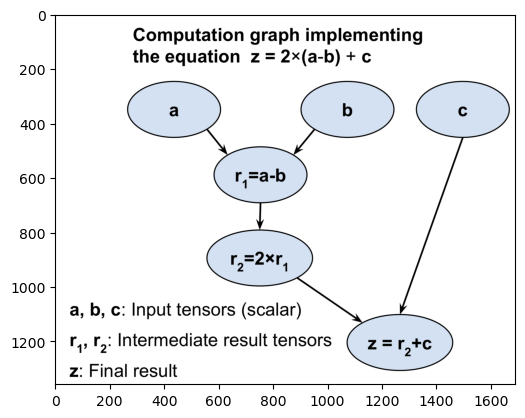

In [4]:
#pytorch的核心是基于有向无环图DAG构建计算图，使用计算图建立输入与输出张量之间的关系
img = Image.open('figures/13_01.png')
plt.imshow(img)

In [5]:
def compute_z(a,b,c):
    r1 = torch.sub(a,b)
    r2 = torch.mul(r1,2)
    z = torch.add(r2,c)
    return z

In [6]:
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


In [7]:
#可计算张量，只有浮点数和复数（dtype=float32/complex）才可以计算梯度，要通过requires_grad=True设置该向量为可微向量，默认为False
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True) 
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [ ]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)
w.requires_grad_()
print(w.requires_grad)

In [12]:
#使用Glorot方法初始化张量
torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [13]:
#在nn.Module的子类中定义两个张量，可以把这两个张量看作权重，使用自动微分计算其梯度
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

In [14]:
###13.4使用自动微分计算梯度
#13.4.1计算损失函数关于可微变量的梯度
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)
# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)
tensor([-0.5600], grad_fn=<MulBackward0>)


In [ ]:
#13.4.3对抗样本
# 计算损失函数相对于样本的梯度可以用于生成对抗样本，在计算机视觉领域，对抗样本是通过向输入样本添加一些小的、不易察觉的噪声（或扰动）而生成的样本，对抗样本会导致深度神经网络将对抗样本错误分类

In [15]:
####13.5使用torch.nn模块简化常见结构
#13.5.1使用nn.Sequential实现模型，网络层以级联的方式连接形成模型，下例构建一个有两个全连接层的网络模型
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

上述的model中首先定义了一个（4，16）的全连接层，该连接层的输出作为第一个ReLU的输入，然后该ReLU的输出作为第二个（16，32）全连接层的输入，该全连接层的输出作为第二个ReLU的输入
全连接层：是每一个结点都与上一层的所有结点相连，用来把前边提取到的特征综合起来。由于其全相连的特性，一般全连接层的参数也是最多的。

In [17]:
#对第一个全连接层通过指定权重的初始化分布来进行初始化，对第二个全连接层权重进行L1正则化
#L1范数正则化（ L1 regularization 或 lasso ）是机器学习（machine learning）中重要的手段，在支持向量机（support vector machine）学习过程中，实际是一种对于成本函数(cost function)求解最优的过程，因此，L1范数正则化通过向成本函数中添加L1范数，使得学习得到的结果满足稀疏化(sparsity)，从而方便人们提取特征。L1范数（L1 norm）是指向量中各个元素绝对值之和
nn.init.xavier_uniform_(model[0].weight)
 
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [18]:
#13.5.2选择损失函数
#在优化算法的选择上，SDG和Adam是最常用的优化算法，损失函数的选择取决于具体任务，例如在回归问题中可以使用均方误差作为损失函数
#在本例中使用SDG优化器和交叉熵损失函数进行二分类
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

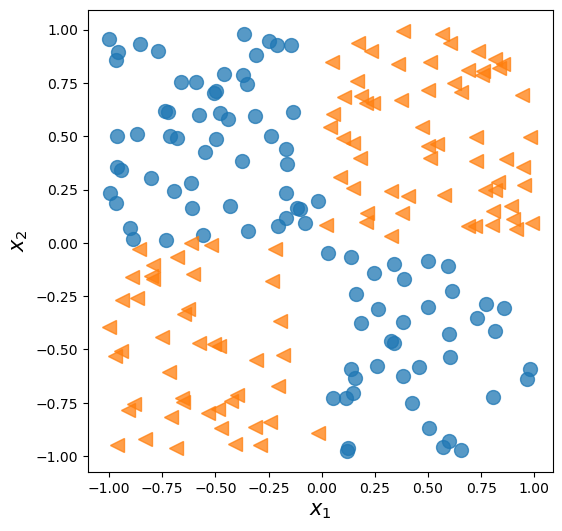

In [19]:
#13.5.3解决XOR分类问题
#XOR分类问题是计算机科学和人工智能领域的一个经典问题，其特征是输入数据是线性不可分的，感知机无法直接解决。‌ XOR问题在研究神经网络时，暴露了早期感知机模型的局限性‌。
#XOR问题的定义是：当两个输入相同时输出为0，当两个输入不同时输出为1。这是一个二元逻辑运算，属于线性不可分问题‌。
#为了解决XOR分类问题，需要使用深度神经网络。深度神经网络能够处理非线性问题，通过多层网络结构和非线性激活函数，能够有效地解决XOR问题‌

np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))        #生成200个数据
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

In [27]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [28]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [29]:
#训练banch为2
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [30]:
#定义了一个名为 train 的函数，该函数用于训练一个模型，并跟踪训练和验证过程中的损失和准确率。
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

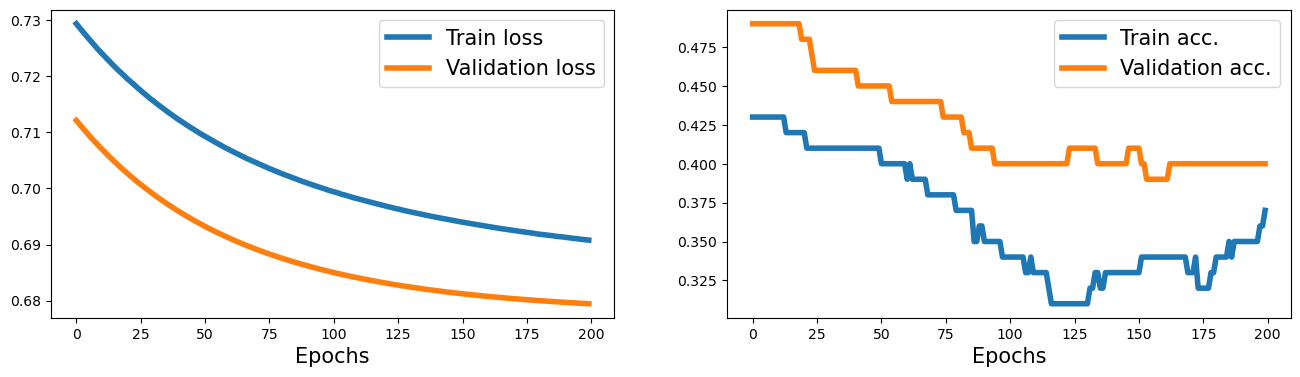

In [31]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

如上图所示，没有隐藏层的简单模型只给出线性决策边界，无法解决XOR问题，训练数据和验证数据的损失函数值都很大，且分类准确率很低

In [32]:
##如下给出含有两个隐藏层的前馈神经网络，以此为例完成含有三个、四个隐藏层的神经网络
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [33]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

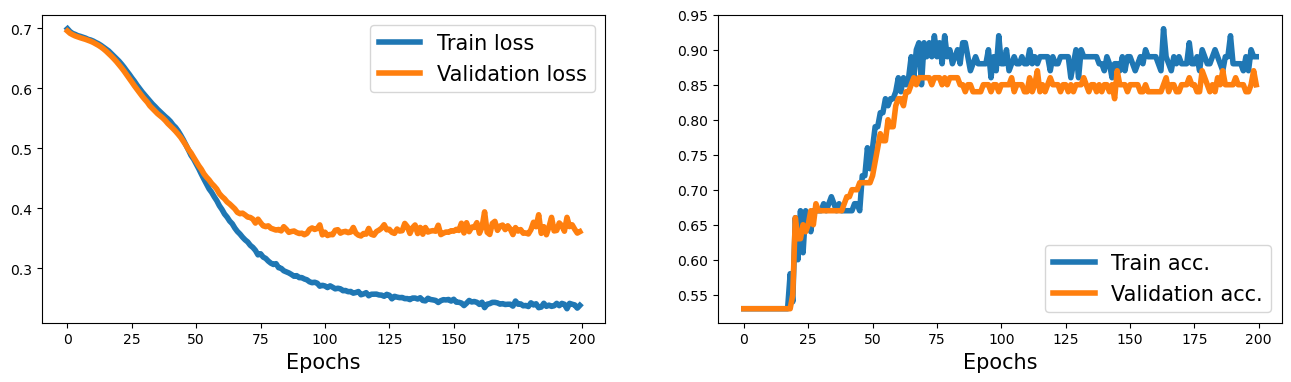

In [34]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [35]:
def pltShow(model):
    history = train(model, num_epochs, train_dl, x_valid, y_valid)
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(history[0], lw=4)
    plt.plot(history[1], lw=4)
    plt.legend(['Train loss', 'Validation loss'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)
    
    ax = fig.add_subplot(1, 2, 2)
    plt.plot(history[2], lw=4)
    plt.plot(history[3], lw=4)
    plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
    ax.set_xlabel('Epochs', size=15)

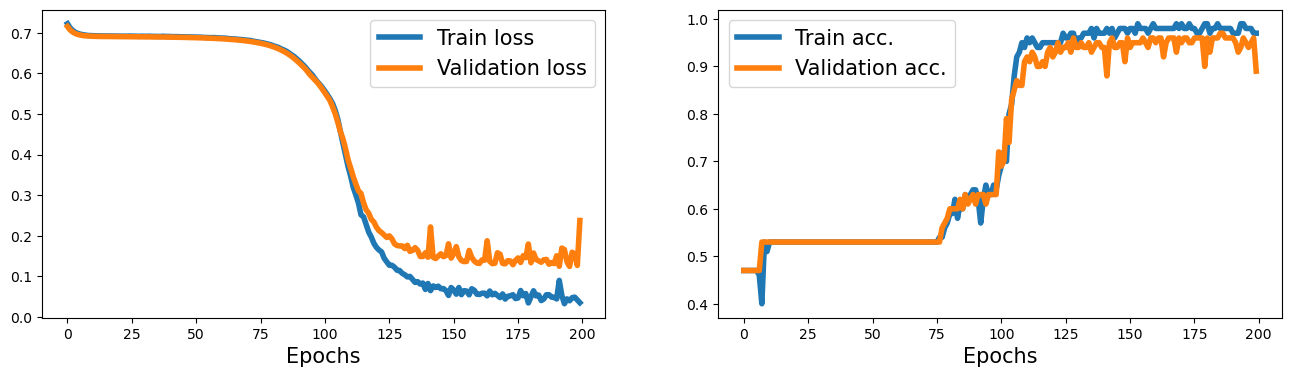

In [36]:
#4层
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model
pltShow(model)